# Full pipeline for 2021-Lband observations
Starts with a chosen version of calibrated level5 maps then: 
 - Constructs different subsets of maps splitting by either dish or observation block (scan) or both
 - Tidies the maps, triming edges, making all lines-of-sight consistently complete
 - Shows summary plots (maps and spectra)
 - Begins PCA analysis on the data, showing:
   - eigenvalue amplitudes
   - eigenmode spectra
   - covariance matrices
   - projected maps of each dominant eigenmodes
 - Foreground cleans each sub-set showing results for increasing number of modes removed
 - Being power spectrum estimation involving:
   - regrid of the maps into comoving (Mpc/h) space
   - optional tapering with e.g. with Blackman windows
   - spherically averaged P(k) for sub-sets and their cross-correlation
   - 2D cylindrical analysis of power
 - Further tests:
   - null tests
   - jackknifing
   
# Still to-do
 - transfer function implementation (tricky for cross-correlation of different sub-sets)
 - angular tapering window (Isa using Tukey window with her work)
 - ....


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (14, 7)

### Build subset from level5 maps to cross-correlate: 

In [30]:
# Read-in some level6 data just to obtain coordinates:
filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
counts_file = filestem + 'Nscan966_Npix_count_cube_p0.3d_sigma3.0_iter2.fits'
null0,null1,null2,null3,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,counts_file)

level5path = '/scratch3/users/jywang/MeerKLASS2021/level5/0.3/sigma4_count40/re_cali1_round5/' # where individial dish and scan maps are stored
output_path = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/subsetmaps/' # where to save created subsets of combined dish and scan maps
#output_path = None # set None to not overwrite previously saved subset maps

dish_indx = np.arange(64)
scan_indx = np.arange(41)
halfway_dish=32
halfway_scan=15

# Split dishes:
'''
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx[:halfway_dish],scan_indx,verbose=True,output_path=output_path)
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx[halfway_dish:],scan_indx,verbose=True,output_path=output_path)
MKmap_A,w_A,W_A,counts_A = np.load(output_path+'dish0-31_scan0-40.npy') # load pre-saved version
MKmap_B,w_B,W_B,counts_B = np.load(output_path+'dish32-63_scan0-40.npy') # load pre-saved version
'''
# Split scans:
#'''
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx,scan_indx[:halfway_scan],verbose=True,output_path=output_path)
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx,scan_indx[halfway_scan:],verbose=True,output_path=output_path)
MKmap_A,w_A,W_A,counts_A = np.load(output_path+'dish0-63_scan0-14.npy') # load pre-saved version
MKmap_B,w_B,W_B,counts_B = np.load(output_path+'dish0-63_scan15-40.npy') # load pre-saved version
#'''

# Split dishes and scans v1:
'''
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx[:halfway_dish],scan_indx[:halfway_scan],verbose=True,output_path=output_path)
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx[halfway_dish:],scan_indx[halfway_scan:],verbose=True,output_path=output_path)
MKmap_A,w_A,W_A,counts_A = np.load(output_path+'dish0-31_scan0-14.npy') # load pre-saved version
MKmap_B,w_B,W_B,counts_B = np.load(output_path+'dish32-63_scan15-40.npy') # load pre-saved version
'''

# Split dishes and scans v2:
'''
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx[:halfway_dish],scan_indx[halfway_scan:],verbose=True,output_path=output_path)
#MKmap,w,W,counts = Init.subsetmap(level5path,dish_indx[halfway_dish:],scan_indx[:halfway_scan],verbose=True,output_path=output_path)
MKmap_A,w_A,W_A,counts_A = np.load(output_path+'dish0-31_scan15-40.npy') # load pre-saved version
MKmap_B,w_B,W_B,counts_B = np.load(output_path+'dish32-63_scan0-14.npy') # load pre-saved version
'''

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff)
Pmod = cosmo.GetModelPk(zeff)
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
OmegaHI = 1.333333e-3
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))

### Remove incomplete LoS pixels from maps:
MKmap_A,w_A,W_A,counts_A = Init.FilterIncompleteLoS(MKmap_A,w_A,W_A,counts_A)
MKmap_B,w_B,W_B,counts_B = Init.FilterIncompleteLoS(MKmap_B,w_B,W_B,counts_B)

### Trim map edges (can fine-tune boarders if needed):
MKmap_A,w_A,W_A,counts_A = Init.MapTrim(MKmap_A,w_A,W_A,counts_A,ra,dec,ramin=334,ramax=357,decmin=-35,decmax=-26.5)
MKmap_B,w_B,W_B,counts_B = Init.MapTrim(MKmap_B,w_B,W_B,counts_B,ra,dec,ramin=334,ramax=357,decmin=-35,decmax=-26.5)

### Plot maps and spectra:

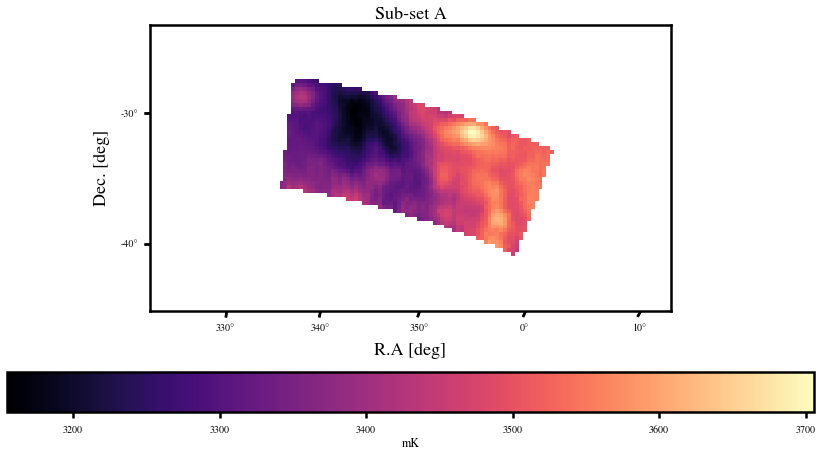

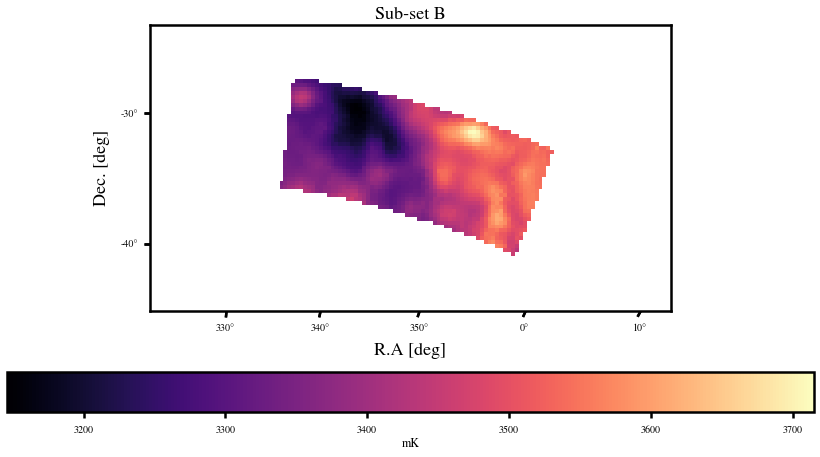

<Figure size 1008x504 with 0 Axes>

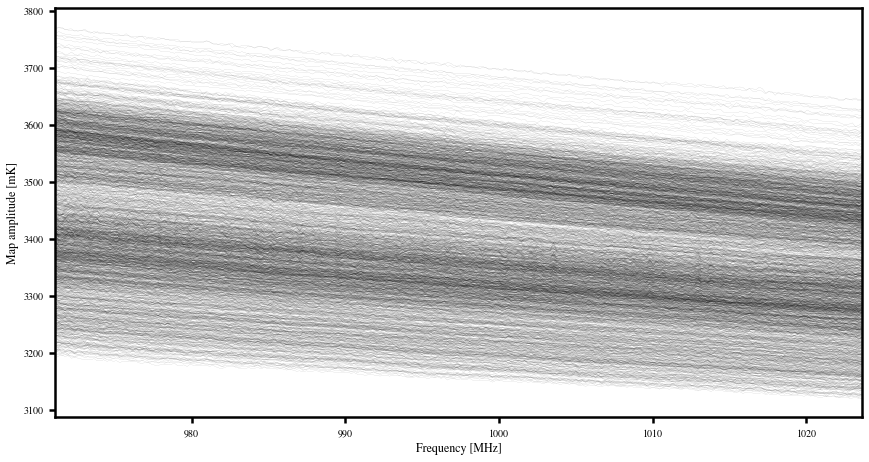

In [31]:
plot.Map(MKmap_A,W=W_A,map_ra=ra,map_dec=dec,wproj=wproj,title='Sub-set A')
plot.Map(MKmap_B,W=W_B,map_ra=ra,map_dec=dec,wproj=wproj,title='Sub-set B')
plot.LoSspectra(MKmap_A,W=W_A,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

### Examine PCA eigenmodes and covariance matrix:

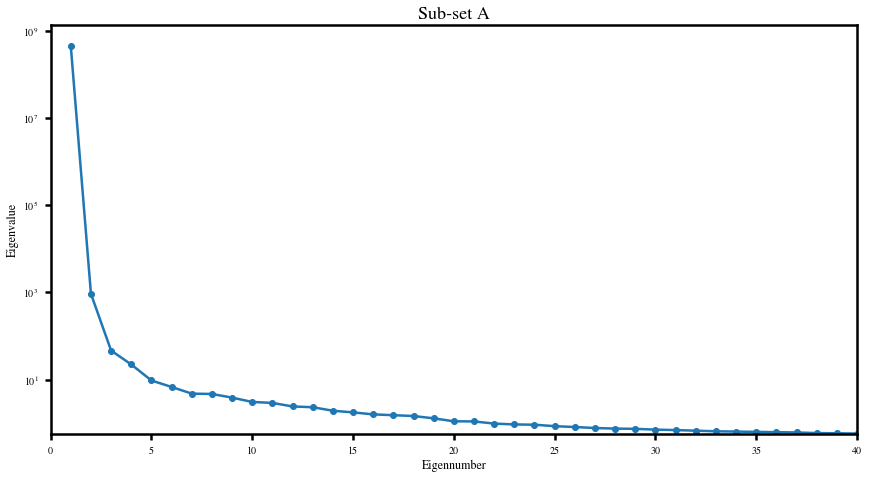

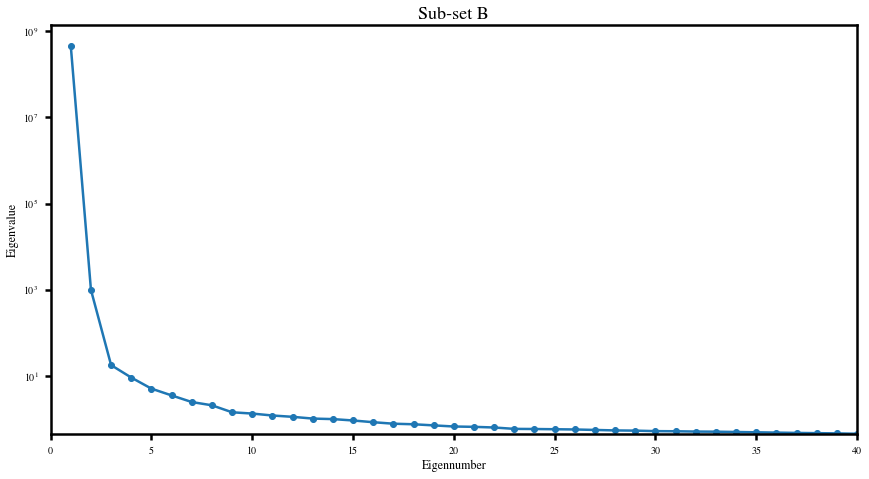

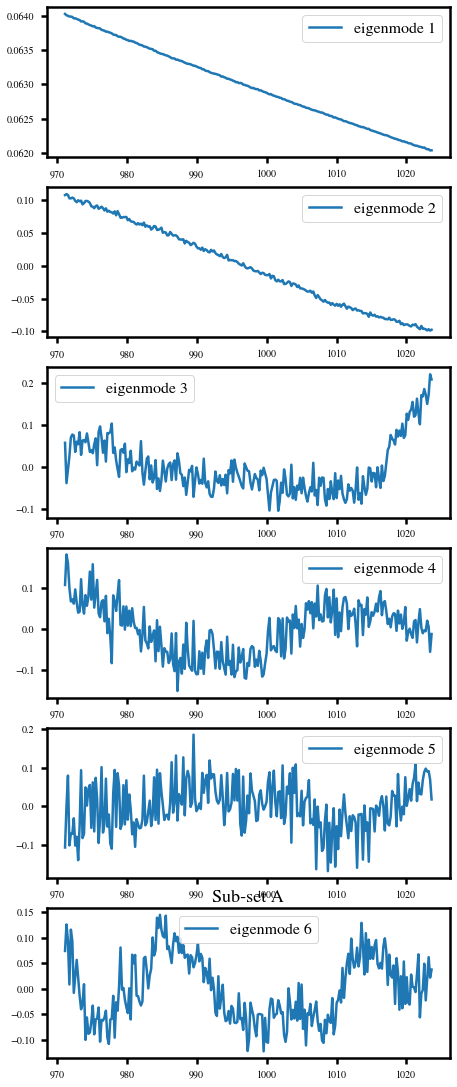

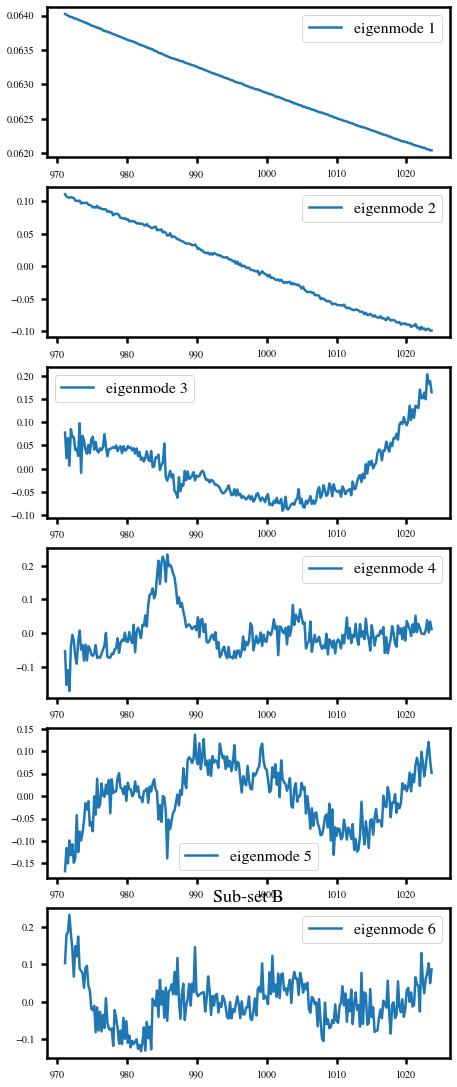

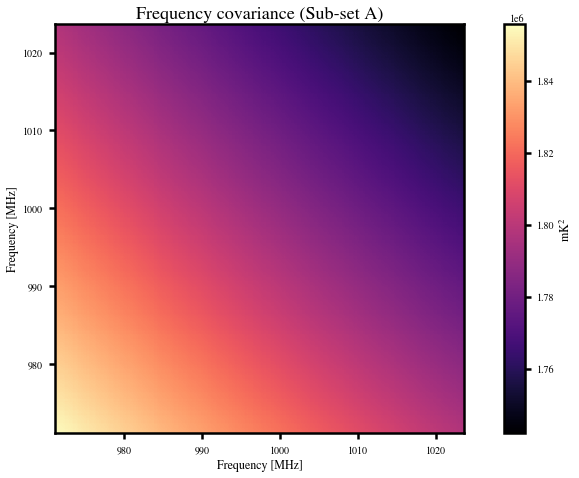

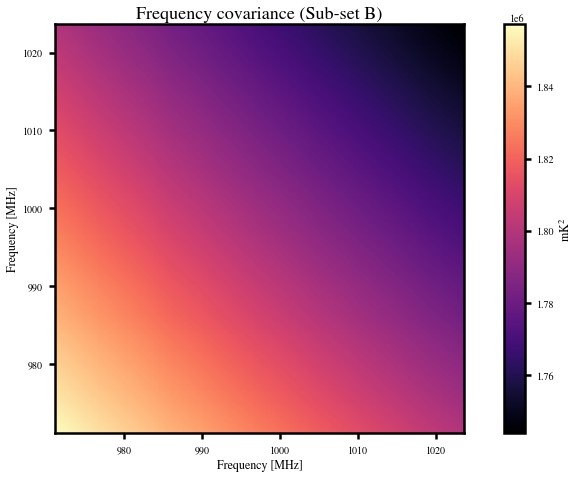

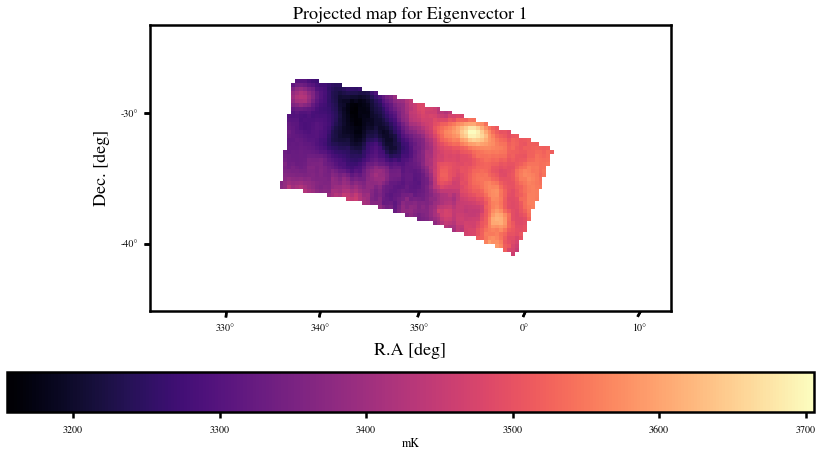

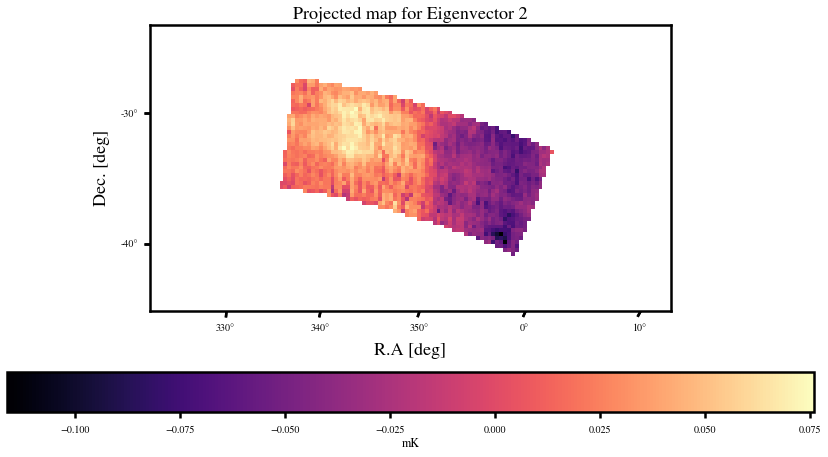

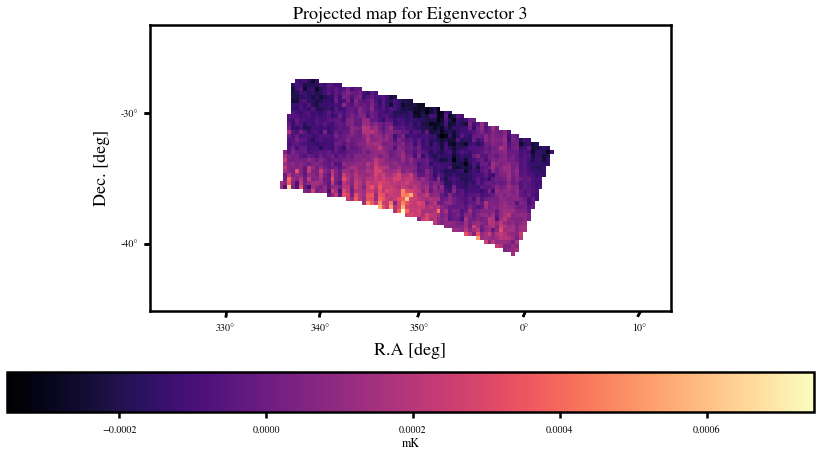

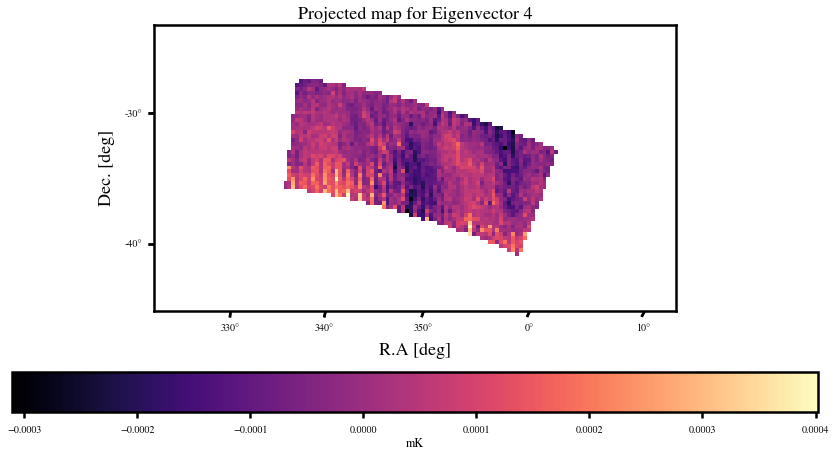

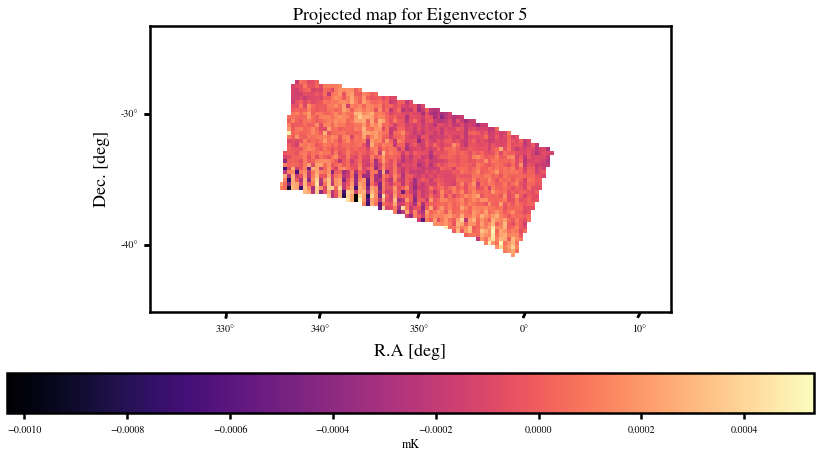

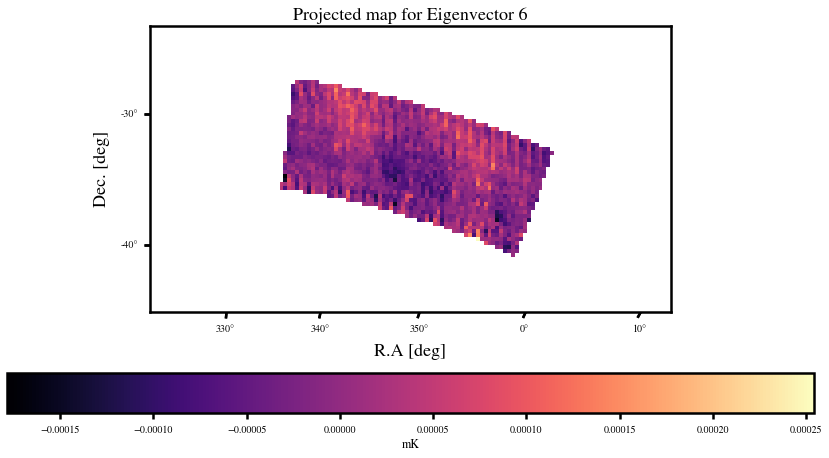

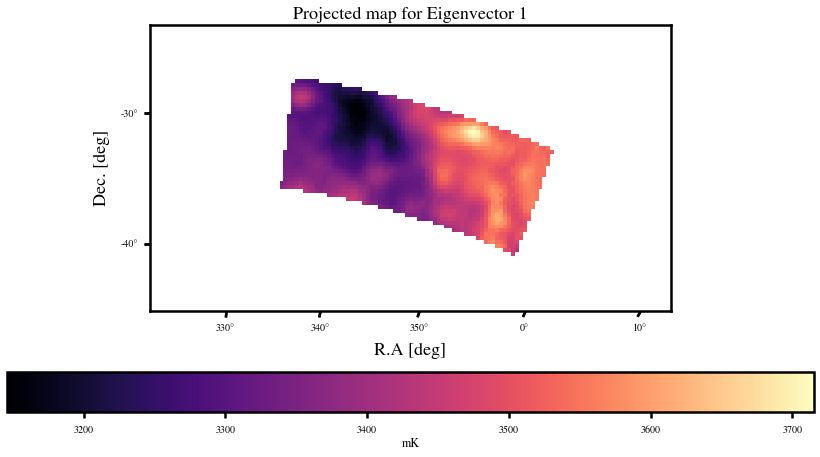

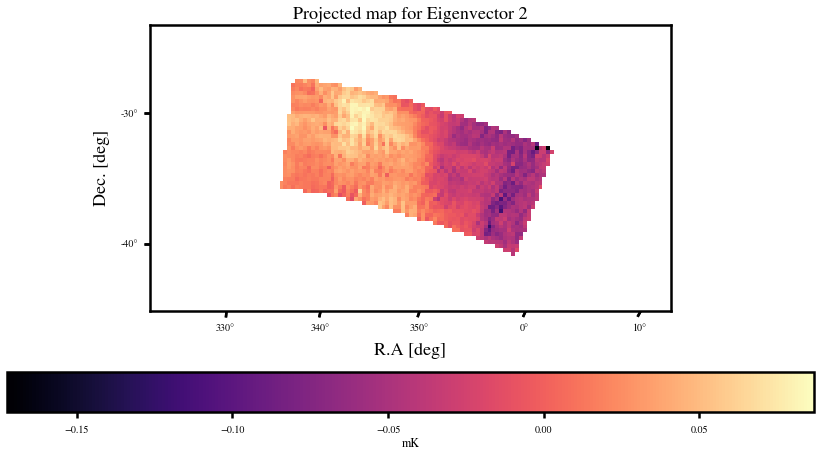

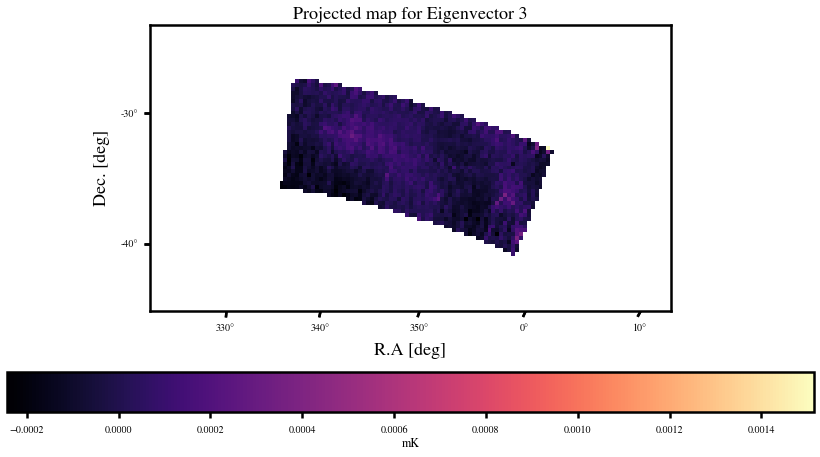

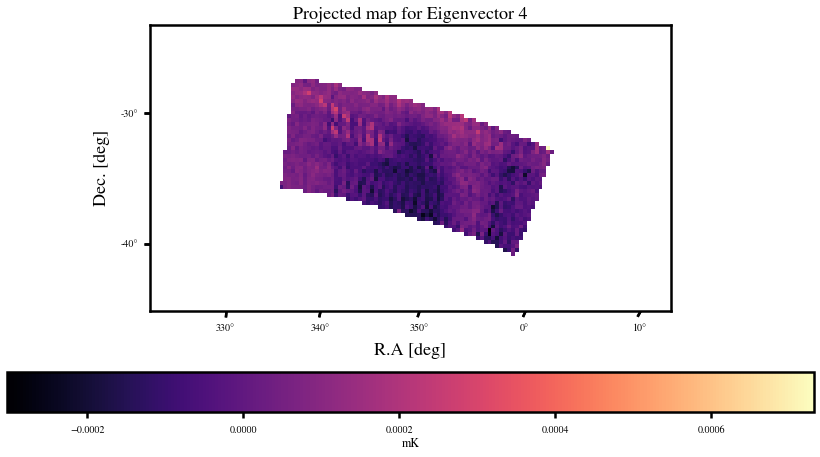

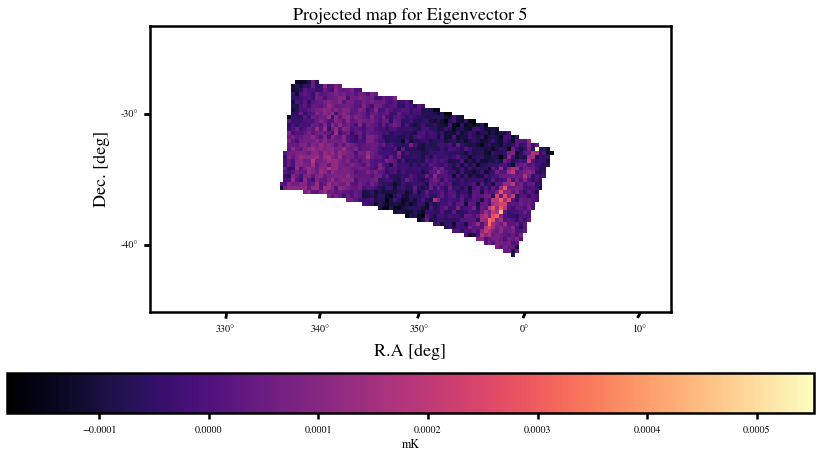

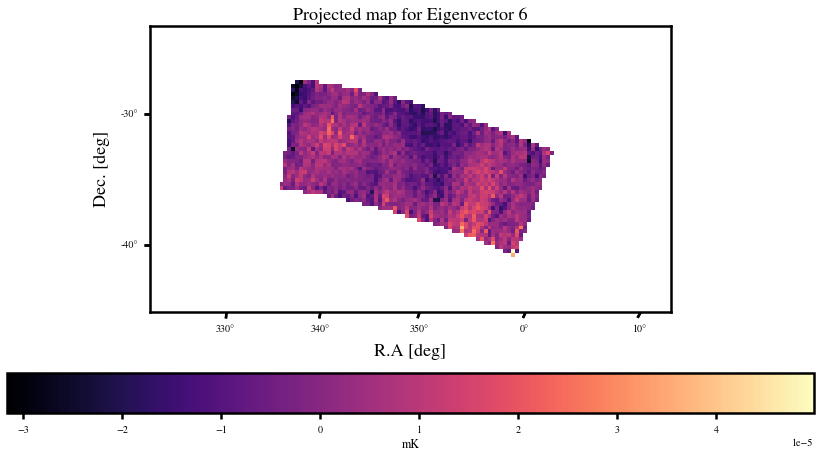

In [32]:
import foreground
C_A,eignumb_A,eigenval_A,V_A = foreground.PCAclean(MKmap_A,N_fg=1,W=W_A,w=None,returnAnalysis=True)
C_B,eignumb_B,eigenval_B,V_B = foreground.PCAclean(MKmap_B,N_fg=1,W=W_B,w=None,returnAnalysis=True)
plot.EigenSpectrum(eignumb_A,eigenval_A,title='Sub-set A')
plot.EigenSpectrum(eignumb_B,eigenval_B,title='Sub-set B')
plot.Eigenmodes(nu,V_A,title='Sub-set A')
plot.Eigenmodes(nu,V_B,title='Sub-set B')
plot.FrequencyCovariance(C_A,nu,title='Frequency covariance (Sub-set A)')
plot.FrequencyCovariance(C_B,nu,title='Frequency covariance (Sub-set B)')
plot.ProjectedEigenmodeMaps(MKmap_A,W_A,V_A,ra,dec,wproj)
plot.ProjectedEigenmodeMaps(MKmap_B,W_B,V_B,ra,dec,wproj)
plt.show()

### Plot foreground cleaned maps:

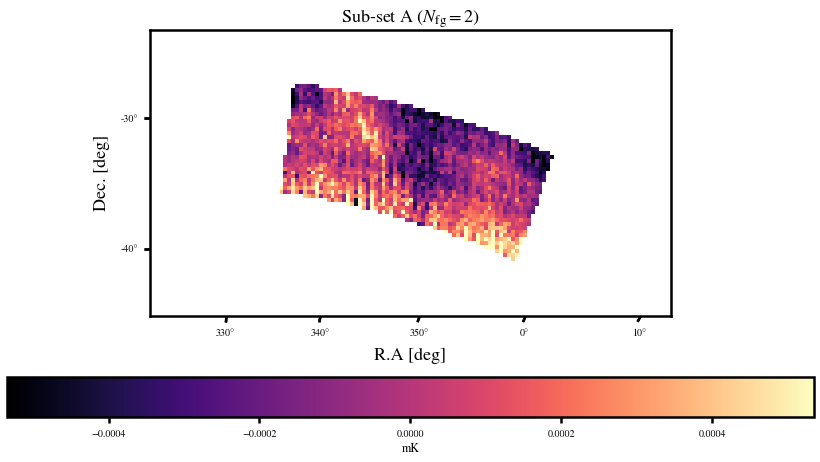

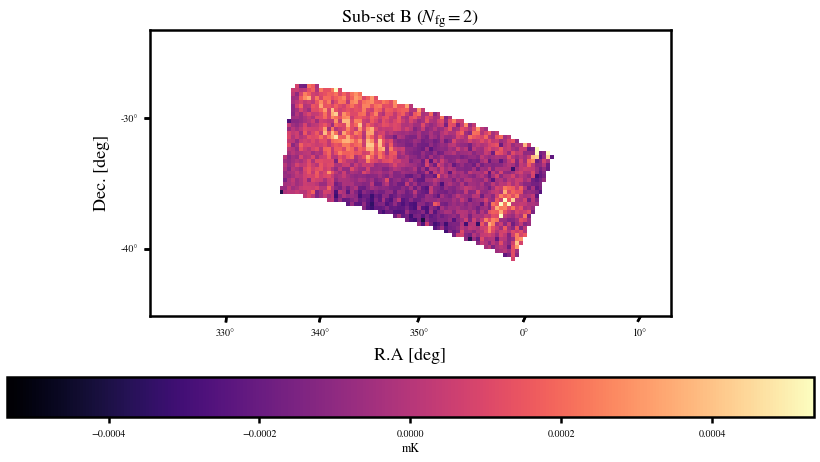

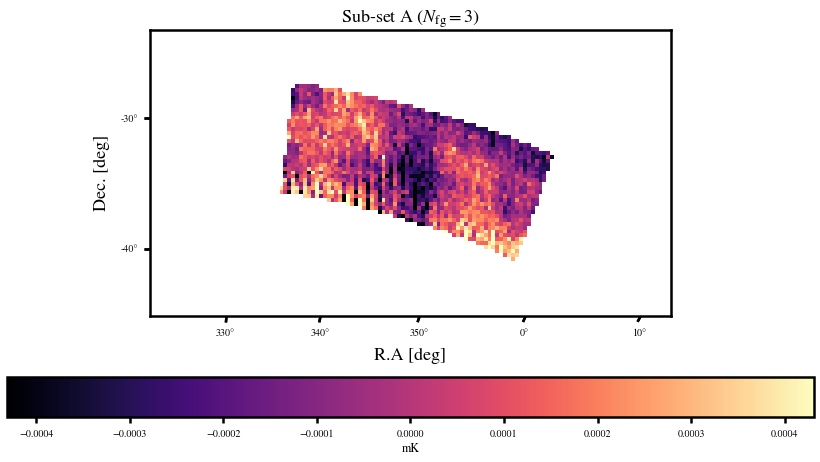

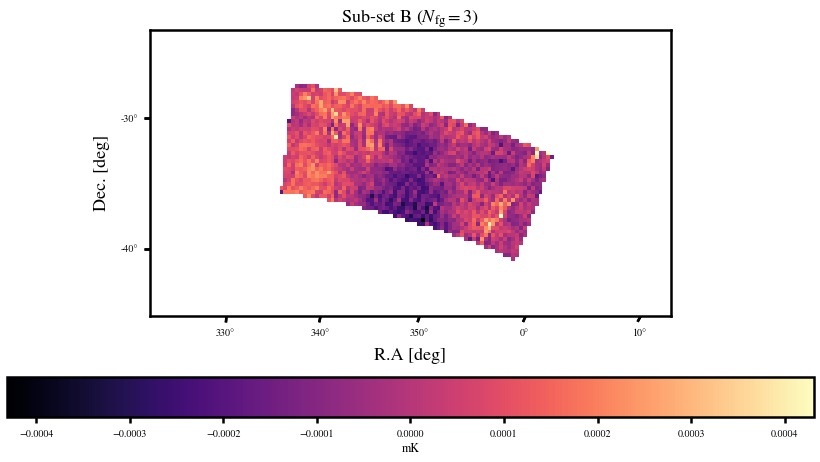

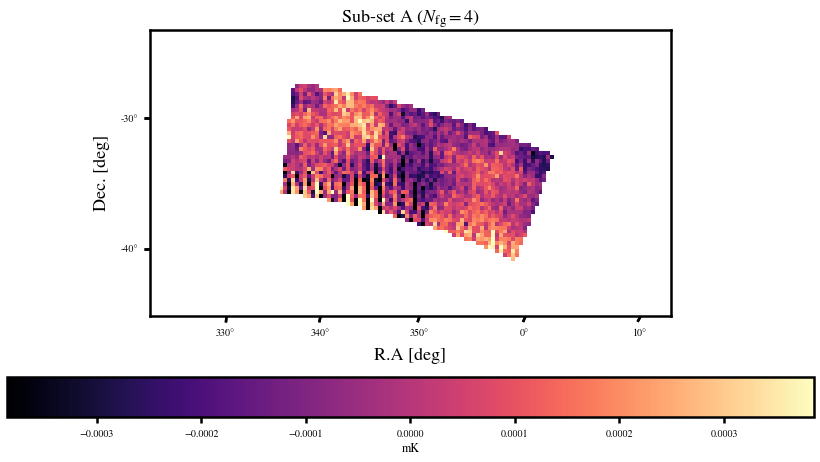

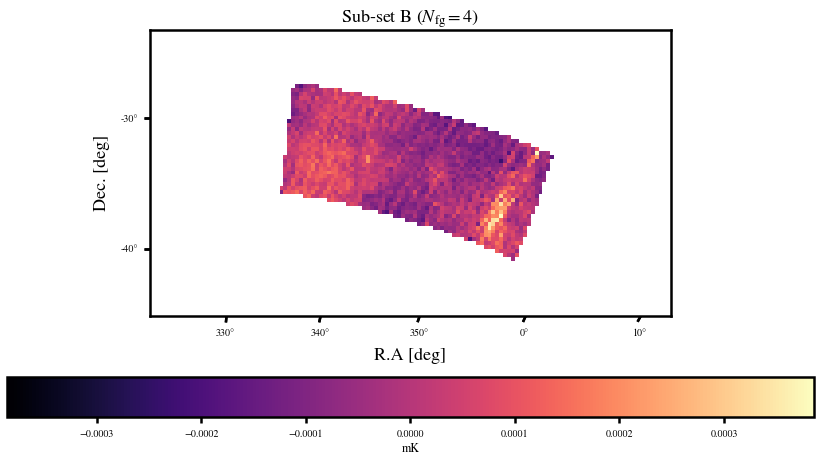

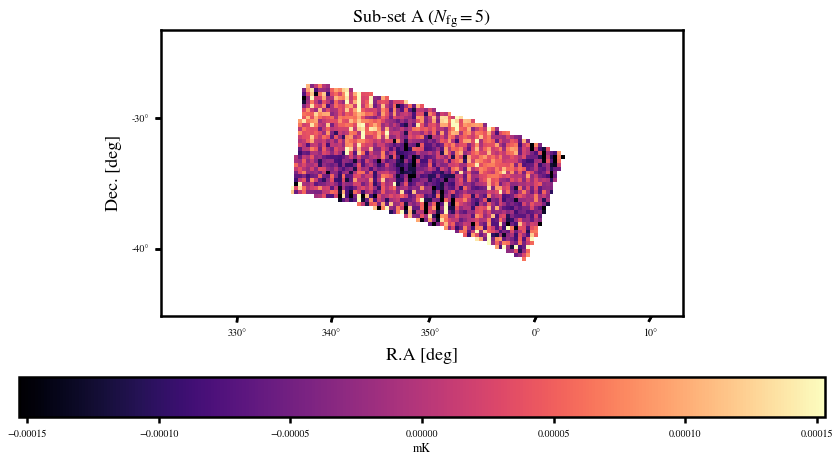

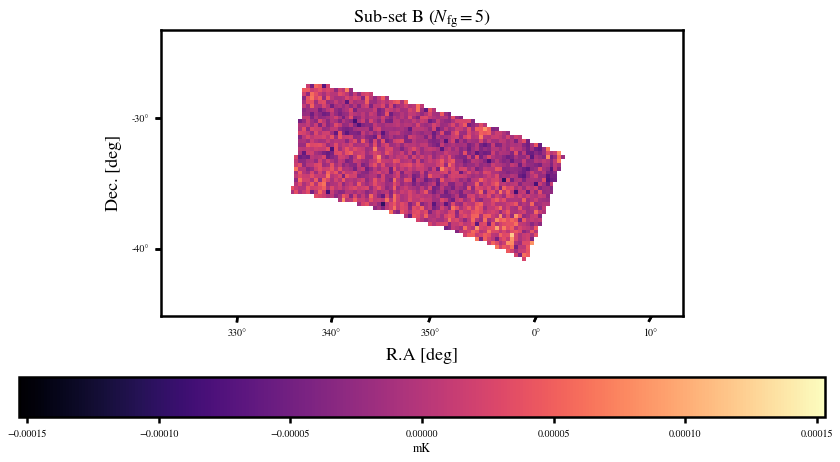

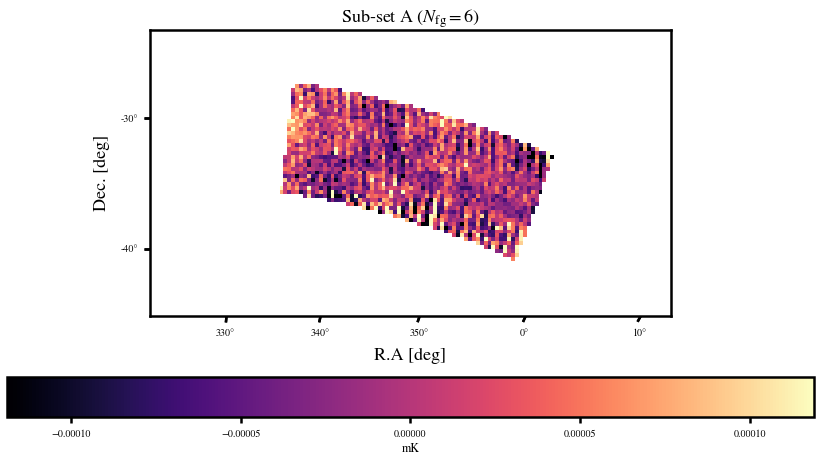

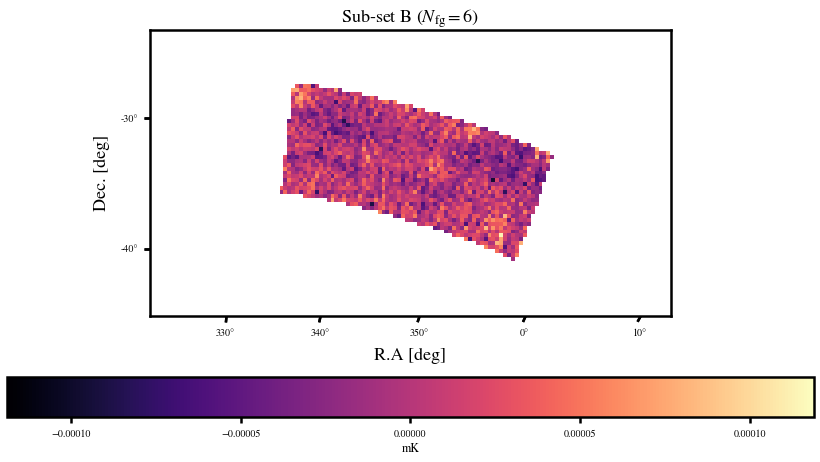

In [33]:
N_fgs = [2,3,4,5,6]
for i in range(len(N_fgs)):
    MKmap_clean_A = foreground.PCAclean(MKmap_A,N_fg=N_fgs[i],W=W_A,w=None)
    MKmap_clean_B = foreground.PCAclean(MKmap_B,N_fg=N_fgs[i],W=W_B,w=None)
    mapcut_A = 5*np.std(np.mean(MKmap_clean_A,2))
    mapcut_B = 5*np.std(np.mean(MKmap_clean_B,2))
    mapcut = np.max([mapcut_A,mapcut_B])
    plot.Map(MKmap_clean_A,map_ra=ra,map_dec=dec,wproj=wproj,W=W_A,title=r'Sub-set A ($N_{\rm fg}=%s)$'%N_fgs[i],vmin=-mapcut,vmax=mapcut)
    plot.Map(MKmap_clean_B,map_ra=ra,map_dec=dec,wproj=wproj,W=W_B,title=r'Sub-set B ($N_{\rm fg}=%s)$'%N_fgs[i],vmin=-mapcut,vmax=mapcut)
plt.show()

### Power spectrum measurement and modelling:

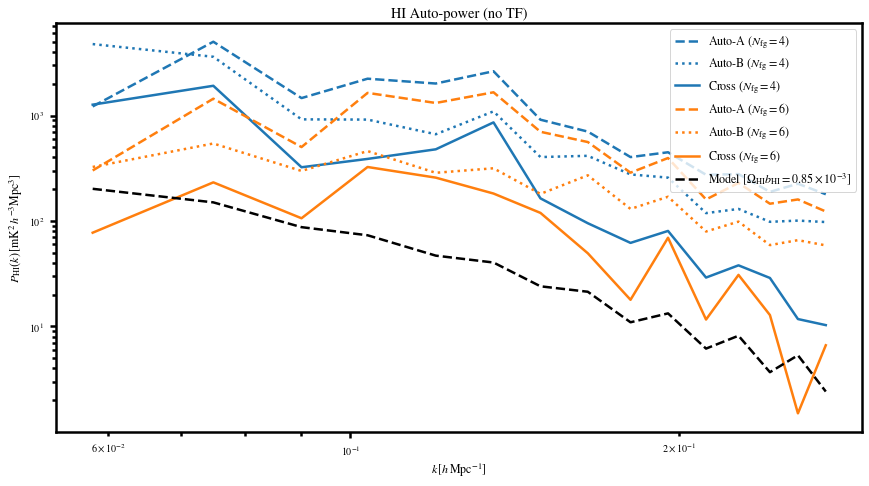

In [34]:
import power # All power spectrum calculations performed in this script
import model
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
nx,ny,nz = np.shape(MKmap_A)

doBlackman = False # Blackman window function to apply to maps and weights to taper edges along z direction
if doBlackman==True: blackman = np.reshape( np.tile(np.blackman(nz), (nx,ny)) , (nx,ny,nz) ) # Blackman function along every LoS
else: blackman = 1

import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
nx_rg,ny_rg,nz_rg = int(nx/2),int(ny/2),int(nz/2) # number of pixels in Comoving space to grid to
ndim = nx_rg,ny_rg,nz_rg

N_fgs = [4,6]
colors = ['tab:blue','tab:orange','tab:red']
for i in range(len(N_fgs)):
    MKmap_clean_A = foreground.PCAclean(MKmap_A,N_fg=N_fgs[i],W=W_A,w=None)
    MKmap_clean_B = foreground.PCAclean(MKmap_B,N_fg=N_fgs[i],W=W_B,w=None)
    MKmap_clean_rg_A,dims,dims0 = grid.comoving(blackman*MKmap_clean_A,ra,dec,nu,W=W_A,ndim=ndim)
    MKmap_clean_rg_B,dims,dims0 = grid.comoving(blackman*MKmap_clean_B,ra,dec,nu,W=W_B,ndim=ndim)
    w_rg_A,dims,dims0 = grid.comoving(blackman*w_A,ra,dec,nu,W=W_A,ndim=ndim)
    w_rg_B,dims,dims0 = grid.comoving(blackman*w_B,ra,dec,nu,W=W_B,ndim=ndim)
    W_rg_A,dims,dims0 = grid.comoving(blackman*W_A,ra,dec,nu,W=W_A,ndim=ndim)
    W_rg_B,dims,dims0 = grid.comoving(blackman*W_B,ra,dec,nu,W=W_B,ndim=ndim)
    lx,ly,lz,nx_rg,ny_rg,nz_rg = dims
    # Measure and plot power spectrum:
    Pk_A,k,nmodes = power.Pk(MKmap_clean_rg_A,MKmap_clean_rg_A,dims,kbins,corrtype='HIauto',w1=w_rg_A,w2=w_rg_A,W1=W_rg_A,W2=W_rg_A)
    Pk_B,k,nmodes = power.Pk(MKmap_clean_rg_B,MKmap_clean_rg_B,dims,kbins,corrtype='HIauto',w1=w_rg_B,w2=w_rg_B,W1=W_rg_B,W2=W_rg_B)
    Pk_AB,k,nmodes = power.Pk(MKmap_clean_rg_A,MKmap_clean_rg_B,dims,kbins,corrtype='HIauto',w1=w_rg_A,w2=w_rg_B,W1=W_rg_A,W2=W_rg_B)
    plt.plot(k,Pk_A,label=r'Auto-A ($N_{\rm fg}=%s$)'%N_fgs[i],ls='--',color=colors[i])
    plt.plot(k,Pk_B,label=r'Auto-B ($N_{\rm fg}=%s$)'%N_fgs[i],ls=':',color=colors[i])
    plt.plot(k,Pk_AB,label=r'Cross ($N_{\rm fg}=%s$)'%N_fgs[i],color=colors[i])
pkmod,k = model.PkMod(Pmod,dims,kbins,b_HI,b_HI,f,sig_v,Tbar1=Tbar,Tbar2=Tbar,r=1,R_beam1=R_beam,R_beam2=R_beam,w1=w_rg_A,w2=w_rg_B,W1=W_rg_A,W2=W_rg_B,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.loglog()
plt.legend(fontsize=12,loc='upper right')
plt.title('HI Auto-power (no TF)')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^{3}]$')
plt.show()

### 2D Power:

/users/scunnington/.conda/envs/meerpower_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/scunnington/.conda/envs/meerpower_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


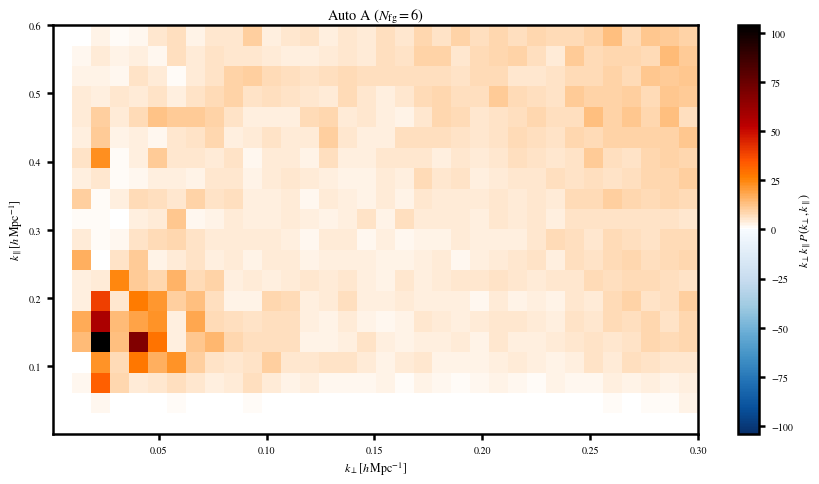

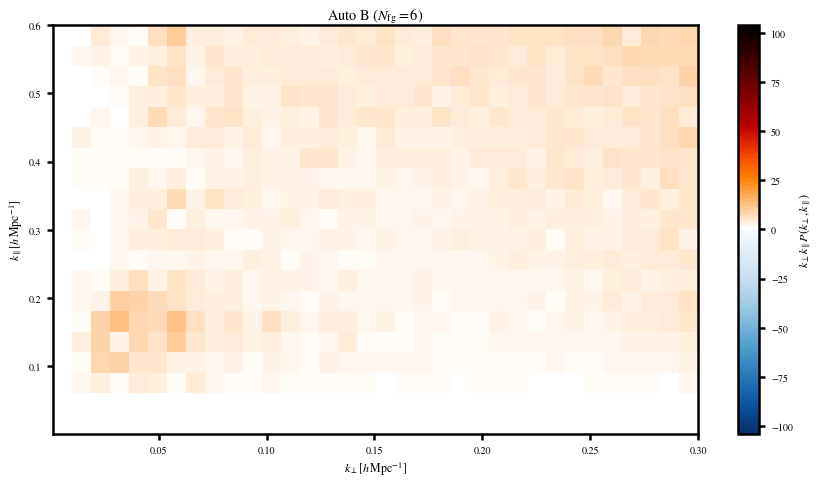

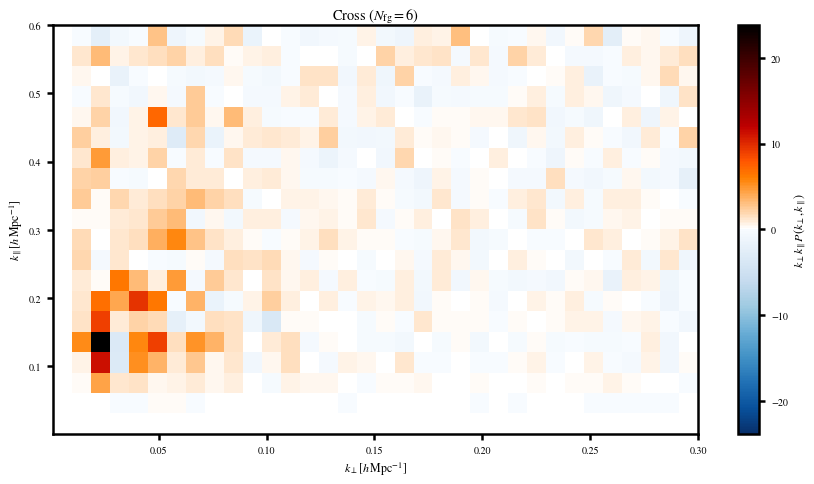

In [35]:
kperpbins = np.linspace(0.001,0.3,35)
kparabins = np.linspace(0.001,0.6,21)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kperpgrid = np.tile(kperpcen,(len(kparacen),1))
kparagrid = np.tile(kparacen,(len(kperpcen),1))
kparagrid = np.swapaxes(kparagrid,0,1)
kgrid = kperpcen * kparacen[:,np.newaxis]

import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

Pk2D_A,k2d,nmodes = power.Pk2D(MKmap_clean_rg_A,MKmap_clean_rg_A,dims,kperpbins,kparabins,w1=w_rg_A,w2=w_rg_A,W1=W_rg_A,W2=W_rg_A)
Pk2D_B,k2d,nmodes = power.Pk2D(MKmap_clean_rg_B,MKmap_clean_rg_B,dims,kperpbins,kparabins,w1=w_rg_B,w2=w_rg_B,W1=W_rg_B,W2=W_rg_B)
Pk2D_AB,k2d,nmodes = power.Pk2D(MKmap_clean_rg_A,MKmap_clean_rg_B,dims,kperpbins,kparabins,w1=w_rg_A,w2=w_rg_B,W1=W_rg_A,W2=W_rg_B)
vmax = np.max([kgrid*Pk2D_A,kgrid*Pk2D_B,kgrid*Pk2D_AB])
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D_A,cmap=mycmap,vmin=-vmax,vmax=vmax)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Auto A ($N_{\rm fg}=%s$) '%N_fgs[-1])
plt.show()
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D_B,cmap=mycmap,vmin=-vmax,vmax=vmax)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Auto B ($N_{\rm fg}=%s$) '%N_fgs[-1])
plt.show()
vmax = np.max(kgrid*Pk2D_AB)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D_AB,cmap=mycmap,vmin=-vmax,vmax=vmax)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Cross ($N_{\rm fg}=%s$) '%N_fgs[-1])
plt.show()

### Jackknife tests:

72


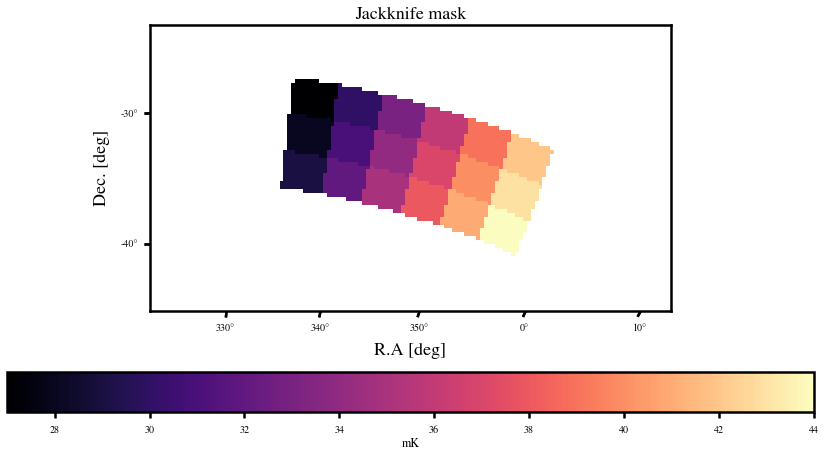

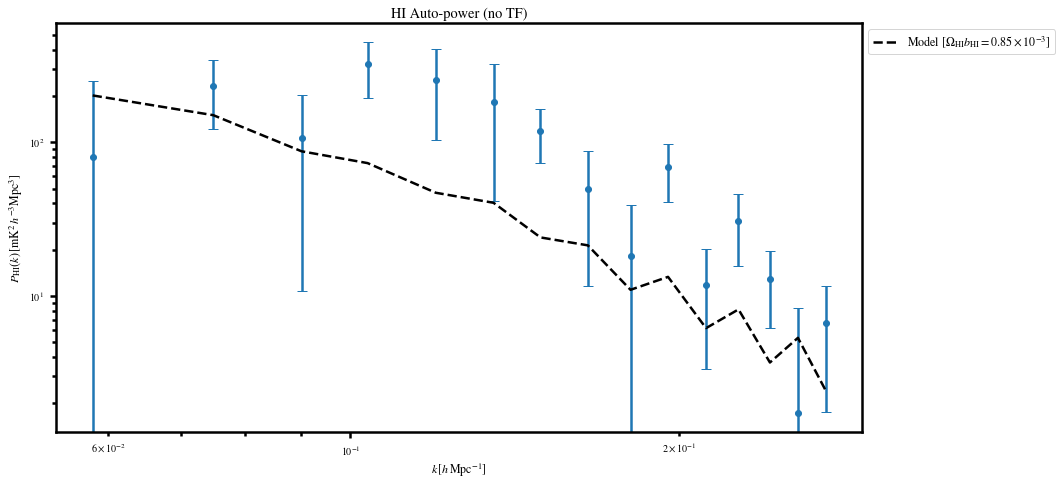

In [36]:
### Chose number of jackknife sub-samples based on how much to split data along each dimension:
nrajack = 7
ndecjack = 4
nzjack = 4

ra_jacks = np.linspace(334,357,nrajack)
dec_jacks = np.linspace(-26.5,-35,ndecjack)
nzi = np.linspace(0,nz-1,nz)
njack = (len(ra_jacks)-1) * (len(dec_jacks)-1)

print(njack*nzjack)

jackmask = np.zeros((nx,ny,nz))
jacklabel = 0
for i in range(len(ra_jacks)-1):
    for j in range(len(dec_jacks)-1):
        jackmask[ (ra>ra_jacks[i]) & (ra<ra_jacks[i+1]) & (dec<dec_jacks[j])  & (dec>dec_jacks[j+1]) ] = jacklabel
        jacklabel += 1
for l in range(nzjack):# this makes nzjack layers of jackknife indices along frequency
    jackmask[:,:,int(l*nz/nzjack):int((l+1)*nz/nzjack)] += l*njack

jackmask,w_A,W_A,counts_A = Init.MapTrim(jackmask,w_A,W_A,counts_A,ra,dec,ramin=334,ramax=357,decmin=-35,decmax=-26.5)
plot.Map(jackmask,W=W_A,map_ra=ra,map_dec=dec,wproj=wproj,title='Jackknife mask')
plt.show()

N_fg = 6
MKmap_clean_A = foreground.PCAclean(MKmap_A,N_fg=N_fg,W=W_A,w=None)
MKmap_clean_B = foreground.PCAclean(MKmap_B,N_fg=N_fg,W=W_B,w=None)

'''
Pk_AB_jack = np.zeros((njack*nzjack,nkbin))
#pk2dcrosss = np.zeros((njack*nzjack,len(kparacen),len(kperpcen)))
for i in range(njack*nzjack):
    plot.ProgressBar(i,N=njack*nzjack,header='Jackknifing:')
    MKmap_clean_jackA,w_jackA,W_jackA = np.copy(MKmap_clean_A),np.copy(w_A),np.copy(W_A)
    MKmap_clean_jackB,w_jackB,W_jackB = np.copy(MKmap_clean_B),np.copy(w_B),np.copy(W_B)
    MKmap_clean_jackA[jackmask==i],w_jackA[jackmask==i],W_jackA[jackmask==i] = 0,0,0
    MKmap_clean_jackB[jackmask==i],w_jackB[jackmask==i],W_jackB[jackmask==i] = 0,0,0
    #plot.Map(W_jackA,W=W_jackA,map_ra=ra,map_dec=dec,wproj=wproj)
    #plt.show()

    MKmap_clean_rg_jackA,dims,dims0 = grid.comoving(blackman*MKmap_clean_jackA,ra,dec,nu,W=W_jackA,ndim=ndim)
    MKmap_clean_rg_jackB,dims,dims0 = grid.comoving(blackman*MKmap_clean_jackB,ra,dec,nu,W=W_jackB,ndim=ndim)
    w_rg_jackA,dims,dims0 = grid.comoving(blackman*w_jackA,ra,dec,nu,W=W_jackA,ndim=ndim)
    w_rg_jackB,dims,dims0 = grid.comoving(blackman*w_jackB,ra,dec,nu,W=W_jackB,ndim=ndim)
    W_rg_jackA,dims,dims0 = grid.comoving(blackman*W_jackA,ra,dec,nu,W=W_jackA,ndim=ndim)
    W_rg_jackB,dims,dims0 = grid.comoving(blackman*W_jackB,ra,dec,nu,W=W_jackB,ndim=ndim)
   
    Pk_AB_jack[i],k,nmodes = power.Pk(MKmap_clean_rg_jackA,MKmap_clean_rg_jackB,dims,kbins,corrtype='HIauto',w1=w_rg_jackA,w2=w_rg_jackB,W1=W_rg_jackA,W2=W_rg_jackB)

np.save('data/pkcross_jacks',Pk_AB_jack)
#np.save('data/pk2dcrosss_jacks',pk2dcrosss)
'''
Pk_AB_jack = np.load('data/pkcross_jacks.npy')
#pk2dcrosss = np.load('data/pk2dcrosss_jacks.npy')
N_jack = np.shape(Pk_AB_jack)[0]
sum_ = np.zeros(len(k))
for i in range(N_jack):
    sum_ += (Pk_AB_jack[i] - np.mean(Pk_AB_jack,0))**2
pkerr_jack = np.sqrt( (N_jack - 1) / N_jack * sum_ )

plt.errorbar(k,np.mean(Pk_AB_jack,0),pkerr_jack,marker='o',ls='none')
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.loglog()
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.title('HI Auto-power (no TF)')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^{3}]$')
plt.show()